##How this Notebook is divided?
This notebook is organized as follows:

SECTION 1   : Function Definitions

SECTION 2   : Extracting Features

SECTION 3   : Data Preprocessing and Creating different Combinations of Features Lists

SECTION 4   : Experiments with different Machine Learning models and features/combinations

Section 4.1: Machine Learning Models with Captions

    Section 4.1.1: XGBoost with Captions
    Section 4.1.2: SVR with Captions
    Section 4.1.3: Bayesian Ridge with Captions

Section 4.2: Machine Learning Models with C3D

    Section 4.2.1: XGBoost with C3D
    Section 4.2.2: SVR with C3D
    Section 4.2.3: Bayesian Ridge with C3D

Section 4.3: Machine Learning Models with HMP

    Section 4.3.1: XGBoost with HMP
    Section 4.3.2: SVR with HMP
    Section 4.3.3: Bayesian Ridge with HMP

Section 4.4: Machine Learning Models with InceptionV3

    Section 4.4.1: XGBoost with InceptionV3
    Section 4.4.2: SVR with InceptionV3
    Section 4.4.3: Bayesian Ridge with InceptionV3

Section 4.5: Machine Learning Models with Captions + C3D

    Section 4.5.1: XGBoost with Captions + C3D
    Section 4.5.2: SVR with Captions + C3D
    Section 4.5.3: Bayesian Ridge with Captions + C3D

Section 4.6: Machine Learning Models with Captions + HMP

    Section 4.6.1: XGBoost with Captions + HMP
    Section 4.6.2: SVR with Captions + HMP
    Section 4.6.3: Bayesian Ridge with Captions + HMP

Section 4.7: Machine Learning Models with Captions + C3D + HMP

    Section 4.7.1: XGBoost with Captions + C3D + HMP
    Section 4.7.2: SVR with Captions + C3D + HMP
    Section 4.7.3: Bayesian Ridge with Captions + C3D + HMP

Section 4.8: Machine Learning Models with Captions + C3D + HMP + InceptionV3

    Section 4.8.1: XGBoost with CaptiCaptions + C3D + HMP + InceptionV3
    Section 4.8.2: SVR with Captions + C3D + HMP + InceptionV3
    Section 4.8.3: Bayesian Ridge with Captions + C3D + HMP + InceptionV3
Setion 4.9: Neural Network with Captions Features

Setion 4.10: Neural Network with Captions + C3D + HMP + InceptionV3 Features

SECTION 5   : Selecting the best model with features

SECTION 6   : Predicting Short-term and Long-term memorability scores on Test-Set

    Section 6.1: Importing Test Datasets and Captions
    Section 6.2: Extracting Features(Captions,C3D,HMP and InceptionV3) for Test Dataset
    Section 6.3: Predicting the Scores and Exporting the Results

##Mounting Google Drive

In [2]:
# connect information in the google drive to this colab session

from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


##Setting the working Directory

In [0]:
import os
os.chdir("/content/drive/My Drive/CA684_Assignment/Dev-set")

##Loading Required Libraries

In [5]:
!pip install pyprind

In [6]:
import pandas as pd
from keras import Sequential
from keras import layers
from keras import regularizers
import numpy as np
from string import punctuation
import pyprind
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from glob import glob

Using TensorFlow backend.


##Setting Seed for reproducability

In [0]:
# for reproducability
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

###**1.Required Function Definitions:**

In [0]:
#Function to load C3D features
def load_c3d(captions, c3dPath):
    files = list(captions["video"].values)
    c3dfeatures = []
    for file in files:
        file = c3dPath+file[:-4]+'txt'
        c3dfeatures.append(np.loadtxt(file))
    #print(type(c3dfeatures))
    return c3dfeatures

#Function to load HMP features
def load_hmp(captions, hmp_path):
    files = list(captions["video"].values)
    hmp_features = []
    for file in files:
        file = hmp_path+file[:-4]+'txt'
        with open(file) as f:
            for line in f:
                pairs=line.split()
                HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
                HMP = np.zeros(6075)
            for idx in HMP_temp.keys():
                HMP[idx-1] = HMP_temp[idx]
            hmp_features.append(HMP)
    return hmp_features

#Function to extract captions and video names
def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df


def read_inception(fname):
    """Scan Inception V3 features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            incept_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    
    incept = np.zeros(6075)
    for idx in incept_temp.keys():
        incept[idx-1] = incept_temp[idx]            
    return incept

#Function to calculate Spearman coefficient scores
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])


##**2.Extracting Features(C3D, HMP, InceptionV3 and Captions):**

###Loading Captions and Ground Truth CSV(Dev-set(6000 full set))

In [0]:
# load the captions
cap_path = './Captions/dev-set_video-captions.txt'
df_cap=read_caps(cap_path)

# load the ground truth values
label_path = './Ground-truth/'
labels=pd.read_csv(label_path+'ground-truth.csv')

###C3D features extraction(Dev-set)

In [0]:
#Extract C3D features
c3dPath = '/content/drive/My Drive/CA684_Assignment/Dev-set/C3D/'
c3dfeatures = load_c3d(df_cap,c3dPath)

###HMP features extraction(Dev-set)

In [0]:
#Extract HMP features

hmp_path = '/content/drive/My Drive/CA684_Assignment/Dev-set/HMP/'
hmp_features = load_hmp(df_cap,hmp_path)

In [0]:
#Saving C3D and HMP Features
np.save("/content/drive/My Drive/Features/c3dfeatures.npy",c3dfeatures)
np.save("/content/drive/My Drive/Features/hmp_features.npy",hmp_features)

In [0]:
#Load command to reuse the features
c3dfeatures =  np.load("/content/drive/My Drive/Features/c3dfeatures.npy")
hmp_features =  np.load("/content/drive/My Drive/Features/hmp_features.npy")

In [0]:
len(hmp_features)

6000

In [0]:
df_cap

,video,caption
0,video3.webm,blonde-woman-is-massaged-tilt-down
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,khr-gangsters
3,video8.webm,medical-helicopter-hovers-at-airport
4,video10.webm,couple-relaxing-on-picnic-crane-shot
...,...,...
5995,video7488.webm,beautiful-young-woman-in-front-of-fountains
5996,video7489.webm,focus-pull-from-molting-penguin-to-penguin-col...
5997,video7491.webm,students-walking-in-university-of-mexico
5998,video7492.webm,beautiful-black-woman-at-spa


In [0]:
labels

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10
...,...,...,...,...,...
5995,video7488.webm,0.921,33,1.000,9
5996,video7489.webm,0.909,53,0.839,31
5997,video7491.webm,0.713,33,0.818,11
5998,video7492.webm,0.954,34,1.000,16


###InceptionV3 features extraction(Dev-set)

In [0]:
#Extracting  Inception Features for Dev Set
df_inceptionv3 = pd.DataFrame(columns = ['video', 'arrayInfo'])

#dir_hmp = './dev-set/HMP'
dir_inceptionv3 = '/content/drive/My Drive/CA684_Assignment/Dev-set/InceptionV3/'

for filename in os.listdir(dir_inceptionv3):
    if filename.endswith(".txt"):
        path = os.path.join(dir_inceptionv3, filename)
        array = read_inception(path)
        if "-56" in filename:
          filename.replace('-56','')
          fileName= filename.replace(".txt",".webm")
          df_inceptionv3 = df_inceptionv3.append({'video': fileName, 'arrayInfo': array}, ignore_index=True)
    else:
        break

In [0]:
df_inceptionv3

,video,arrayInfo
0,video10-56.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.663038e-..."
1,video100-56.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,video1001-56.webm,"[0.0, 0.0, 0.0, 0.0, 9.812947e-38, 0.0, 0.0, 2..."
3,video1003-56.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,video1004-56.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.027571e-35, 0.0, 7..."
5,video1005-56.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.408239e-..."
6,video1006-56.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,video1007-56.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,video1009-56.webm,"[0.0, 3.753554e-38, 1.694147e-36, 1.532274e-38..."
9,video101-56.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [0]:
count=0
for item in df_inceptionv3['video']:
  df_inceptionv3['video'][count]=item.replace('-56.webm','.webm')
  count = count + 1

In [0]:
#merging inceptionv3 fetures with captions
df_inception = df_inceptionv3.merge(labels,on=["video"],how="inner")
df_inception.columns
df_inception.head()

,video,arrayInfo,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video10.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.663038e-...",0.950,34,0.900,10
1,video100.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.951,33,0.889,9
2,video1001.webm,"[0.0, 0.0, 0.0, 0.0, 9.812947e-38, 0.0, 0.0, 2...",0.899,34,1.000,12
3,video1003.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.867,34,0.846,13
4,video1004.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.027571e-35, 0.0, 7...",0.753,34,0.571,14


In [0]:
Inceptionv3_features = np.empty((0, 6075))
Inceptionv3_features

for line in df_inception['arrayInfo']:
    #result = do_stuff(line)
    #print(len(line))
    Inceptionv3_features = np.append(Inceptionv3_features, np.array([line]), axis = 0)

In [0]:
#Saving Inceptionv3 features
np.save("/content/drive/My Drive/Features/Inceptionv3_features.npy",Inceptionv3_features)

In [0]:
#To load inceptionv3 features to reuse them
Inceptionv3_features =  np.load("/content/drive/My Drive/Features/Inceptionv3_features.npy")

In [0]:
Inceptionv3_features

array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [3.059923e-29, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 4.914695e-34],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

###Captions features Extraction(Dev-set)

In [12]:
#Preprocessing for Caption Features
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#creating it as a function as it would be needed again for test set features generation
def Processing_captions(df_cap):
  cleaned_captions = []
  for i in range(0, len(df_cap['caption'])):
      text = re.sub('[^a-zA-Z]', ' ', df_cap['caption'][i])
      text = text.lower()
      text = text.split()
      text = [word for word in text if not word in set(stopwords.words('english'))]
      text = ' '.join(text)
      cleaned_captions.append(text)

  #implementing bag of words for the combined captions
  from sklearn.feature_extraction.text import CountVectorizer
  vectorizer = CountVectorizer(analyzer = "word",max_features=3112) 
  captions_bag = vectorizer.fit_transform(cleaned_captions).toarray()
  type(captions_bag)
  return captions_bag

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##**3.Data Preprocessing: Creating Combination of different features lists(Dev-set):**

In [0]:
#Combining C3d and Captions Features
captions_bag = Processing_captions(df_cap)
captions_c3d = (captions_bag.tolist())
counter = 0
for item in range(6000):
    captions_c3d[counter] = np.append(captions_c3d[counter],c3dfeatures[counter],axis=0)
    counter = counter+1

#Combining HMP and Captions Features
captions_hmp = (captions_bag.tolist())
counter = 0
for item in range(6000):
    captions_hmp[counter] = np.append(captions_hmp[counter],hmp_features[counter],axis=0)
    counter = counter+1


#Combining captions_c3d with HMP to form 
captions_c3d_hmp = captions_c3d
counter = 0
for item in range(6000):
    captions_c3d_hmp[counter] = np.append(captions_c3d_hmp[counter],hmp_features[counter],axis=0)
    counter = counter+1
    
#Combining captions_c3d_hmp with InceptionV3 to form 
captions_c3d_hmp_inc = captions_c3d_hmp
counter = 0
for item in range(6000):
    captions_c3d_hmp_inc[counter] = np.append(captions_c3d_hmp_inc[counter],Inceptionv3_features[counter],axis=0)
    counter = counter+1


##Building Machine Learning Models as functions:

In [0]:
def XGBoost_Regressor(x_train,y_train,x_test):
  import xgboost as xgb
  xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                  max_depth = 5, alpha = 10, n_estimators = 10)
  xg_reg.fit(x_train,y_train)
  short_preds = xg_reg.predict(x_test)
  return short_preds

In [0]:
def SVR_Regressor(x_train,y_train,x_test):
  from sklearn.svm import SVR
  regressor = SVR(kernel = 'rbf')
  regressor.fit(x_train, y_train)
  short_pred = regressor.predict(x_test)
  return short_pred

In [0]:
def BR_Regressor(x_train,y_train,x_test):
  from sklearn.linear_model import BayesianRidge
  clf = BayesianRidge(compute_score=True)
  clf.fit(x_train, y_train)
  preds = clf.predict(x_test)
  return preds

##**4.Experimenting with different machine Learning Models(SVR,XGBoost and Bayesian Regression) with Features/Combination of Features:**

Henceforth, I will be changing X which represents feature set and keeping y_short and y_long same for all train and test spliting as they shows the memorability scores.
After that, I will apply the features on SVR, XGBoost and Bayesian Ridge to get their respective predictions and print their Spearman's score accordingly. 
**Note**: y_short and y_long are the short-term and long-term Memorability scores 
mentioned in ground-truth csv of dev-set.

###**4.1 With Captions:**

####Spliting data into Train and Test

In [0]:
X_captions = captions_bag

y_short = labels[['short-term_memorability']].values
y_long = labels[['long-term_memorability']].values

# Splitting the dataset into the Training set and Test set
short_X_train,short_X_test,y_short_train,y_short_test = train_test_split(X_captions,y_short,test_size=0.2,random_state=42)
long_X_train,long_X_test,y_long_train,y_long_test = train_test_split(X_captions,y_long,test_size=0.2,random_state=42)

In [0]:
print('X_train:',short_X_train.shape)
print('Y_train:',y_short_train.shape)
print('X_test:',short_X_test.shape)
print('Y_test:',y_short_test.shape)

X_train: (4800, 3112)
Y_train: (4800, 1)
X_test: (1200, 3112)
Y_test: (1200, 1)


In [0]:
print('X_train:',long_X_train.shape)
print('Y_train:',y_long_train.shape)
print('X_test:',long_X_test.shape)
print('Y_test:',y_long_test.shape)

X_train: (4800, 3112)
Y_train: (4800, 1)
X_test: (1200, 3112)
Y_test: (1200, 1)


####Getting Predictions of XGBoost,SVR and Bayesian Ridge

In [0]:
#XGBoost
short_preds = XGBoost_Regressor(short_X_train,y_short_train,short_X_test)
long_preds = XGBoost_Regressor(long_X_train,y_long_train,long_X_test)

#SVR
svr_short_preds = SVR_Regressor(short_X_train,y_short_train,short_X_test)
svr_long_preds = SVR_Regressor(long_X_train,y_long_train,long_X_test)

#Bayesian Ridge
br_short_preds = BR_Regressor(short_X_train,y_short_train,short_X_test)
br_long_preds = BR_Regressor(long_X_train,y_long_train,long_X_test)

[00:52:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:52:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

####Calculating Spearman's score for short-term and Long-term Memorability

In [0]:
#XGBoost
np.reshape(y_short_test,(1200,))
Get_score(short_preds, y_short_test)

np.reshape(y_long_test,(1200,))
Get_score(long_preds, y_long_test)

#SVR
Get_score(svr_short_preds, y_short_test)
Get_score(svr_long_preds, y_long_test)

#Bayesian Ridge
Get_score(br_short_preds, y_short_test)
Get_score(br_long_preds, y_long_test)

The Spearman's correlation coefficient is: 0.318
The Spearman's correlation coefficient is: 0.120
The Spearman's correlation coefficient is: 0.419
The Spearman's correlation coefficient is: 0.179
The Spearman's correlation coefficient is: 0.447
The Spearman's correlation coefficient is: 0.179


###**4.2 With C3D Features:**

####Spliting data into Train and Test

In [0]:
X_C3DFeatures = c3dfeatures

# Splitting the dataset into the Training set and Test set
short_C3D_X_train,short_C3D_X_test,short_C3D_y_train,short_C3D_y_test = train_test_split(X_C3DFeatures,y_short,test_size=0.2,random_state=42)
long_C3D_X_train,long_C3D_X_test,long_C3D_y_train,long_C3D_y_test = train_test_split(X_C3DFeatures,y_long,test_size=0.2,random_state=42)

In [0]:
print('X_train:',short_C3D_X_train.shape)
print('Y_train:',short_C3D_y_train.shape)
print('X_test:',short_C3D_X_test.shape)
print('Y_test:',short_C3D_y_test.shape)

X_train: (4800, 101)
Y_train: (4800, 1)
X_test: (1200, 101)
Y_test: (1200, 1)


In [0]:
print('X_train:',long_C3D_X_train.shape)
print('Y_train:',long_C3D_y_train.shape)
print('X_test:',long_C3D_X_test.shape)
print('Y_test:',long_C3D_y_test.shape)

X_train: (4800, 101)
Y_train: (4800, 1)
X_test: (1200, 101)
Y_test: (1200, 1)


####Getting Predcitions of XGBoost,SVR and Bayesian Ridge

In [0]:
#XGBoost
short_c3d_preds = XGBoost_Regressor(short_C3D_X_train,short_C3D_y_train,short_C3D_X_test)
long_c3d_preds = XGBoost_Regressor(long_C3D_X_train,long_C3D_y_train,long_C3D_X_test)

#SVR
svr_C3D_short_preds = SVR_Regressor(short_C3D_X_train,short_C3D_y_train,short_C3D_X_test)
svr_C3D_long_preds = SVR_Regressor(long_C3D_X_train,long_C3D_y_train,long_C3D_X_test)

#Bayesian Ridge
br_C3D_short_preds = BR_Regressor(short_C3D_X_train,short_C3D_y_train,short_C3D_X_test)
br_C3D_long_preds = BR_Regressor(long_C3D_X_train,long_C3D_y_train,long_C3D_X_test)

[16:25:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

####Calculating Spearman's score for short-term and Long-term Memorability

In [0]:
#XGBOOST
Get_score(short_c3d_preds, short_C3D_y_test)
Get_score(long_c3d_preds, long_C3D_y_test)

#SVR
Get_score(svr_C3D_short_preds, short_C3D_y_test)
Get_score(svr_C3D_long_preds, long_C3D_y_test)

#Bayesian Ridge
Get_score(br_C3D_short_preds, short_C3D_y_test)
Get_score(br_C3D_long_preds, long_C3D_y_test)

The Spearman's correlation coefficient is: 0.272
The Spearman's correlation coefficient is: 0.135
The Spearman's correlation coefficient is: 0.247
The Spearman's correlation coefficient is: 0.037
The Spearman's correlation coefficient is: 0.282
The Spearman's correlation coefficient is: 0.126


###**4.3 With HMP Features:**

####Spliting data into Train and Test

In [0]:
X_HMPFeatures = hmp_features

# Splitting the dataset into the Training set and Test set
short_HMP_X_train,short_HMP_X_test,short_HMP_y_train,short_HMP_y_test = train_test_split(X_HMPFeatures,y_short,test_size=0.2,random_state=42)
long_HMP_X_train,long_HMP_X_test,long_HMP_y_train,long_HMP_y_test = train_test_split(X_HMPFeatures,y_long,test_size=0.2,random_state=42)

In [0]:
print('X_train:',short_HMP_X_train.shape)
print('Y_train:',short_HMP_y_train.shape)
print('X_test:',short_HMP_X_test.shape)
print('Y_test:',short_HMP_y_test.shape)

X_train: (4800, 6075)
Y_train: (4800, 1)
X_test: (1200, 6075)
Y_test: (1200, 1)


In [0]:
print('X_train:',long_HMP_X_train.shape)
print('Y_train:',long_HMP_y_train.shape)
print('X_test:',long_HMP_X_test.shape)
print('Y_test:',long_HMP_y_test.shape)

X_train: (4800, 6075)
Y_train: (4800, 1)
X_test: (1200, 6075)
Y_test: (1200, 1)


####Getting Predcitions of XGBoost,SVR and Bayesian Ridge

In [0]:
#XGBoost
short_hmp_preds = XGBoost_Regressor(short_HMP_X_train,short_HMP_y_train,short_HMP_X_test)
long_hmp_preds = XGBoost_Regressor(long_HMP_X_train,long_HMP_y_train,long_HMP_X_test)

#SVR
svr_hmp_short_preds = SVR_Regressor(short_HMP_X_train,short_HMP_y_train,short_HMP_X_test)
svr_hmp_long_preds = SVR_Regressor(long_HMP_X_train,long_HMP_y_train,long_HMP_X_test)

#Bayesian Ridge
br_hmp_short_preds = BR_Regressor(short_HMP_X_train,short_HMP_y_train,short_HMP_X_test)
br_hmp_long_preds = BR_Regressor(long_HMP_X_train,long_HMP_y_train,long_HMP_X_test)

[16:26:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

####Calculating Spearman's score for short-term and Long-term Memorability

In [0]:
#XGBOOST
Get_score(short_hmp_preds, short_HMP_y_test)
Get_score(long_hmp_preds, long_HMP_y_test)

#SVR
Get_score(svr_hmp_short_preds, short_HMP_y_test)
Get_score(svr_hmp_long_preds, long_HMP_y_test)

#Bayesian Ridge
Get_score(br_hmp_short_preds, short_HMP_y_test)
Get_score(br_hmp_long_preds, long_HMP_y_test)

The Spearman's correlation coefficient is: 0.259
The Spearman's correlation coefficient is: 0.098
The Spearman's correlation coefficient is: 0.319
The Spearman's correlation coefficient is: 0.103
The Spearman's correlation coefficient is: 0.302
The Spearman's correlation coefficient is: 0.112


###**4.4 With InceptionV3:**

####Spliting data into Train and Test

In [0]:
X_InceptionFeatures = Inceptionv3_features
# Splitting the dataset into the Training set and Test set
short_INC_X_train,short_INC_X_test,short_INC_y_train,short_INC_y_test = train_test_split(X_InceptionFeatures,y_short,test_size=0.2,random_state=42)
long_INC_X_train,long_INC_X_test,long_INC_y_train,long_INC_y_test = train_test_split(X_InceptionFeatures,y_long,test_size=0.2,random_state=42)

In [0]:
print('X_train:',short_INC_X_train.shape)
print('Y_train:',short_INC_y_train.shape)
print('X_test:',short_INC_X_test.shape)
print('Y_test:',short_INC_y_test.shape)

X_train: (4800, 6075)
Y_train: (4800, 1)
X_test: (1200, 6075)
Y_test: (1200, 1)


In [0]:
print('X_train:',long_INC_X_train.shape)
print('Y_train:',long_INC_y_train.shape)
print('X_test:',long_INC_X_test.shape)
print('Y_test:',long_INC_y_test.shape)

X_train: (4800, 6075)
Y_train: (4800, 1)
X_test: (1200, 6075)
Y_test: (1200, 1)


####Getting Predcitions of XGBoost,SVR and Bayesian Ridge

In [0]:
#XGBoost
short_inc_preds = XGBoost_Regressor(short_INC_X_train,short_INC_y_train,short_INC_X_test)
long_inc_preds = XGBoost_Regressor(long_INC_X_train,long_INC_y_train,long_INC_X_test)

#SVR
svr_inc_short_preds = SVR_Regressor(short_INC_X_train,short_INC_y_train,short_INC_X_test)
svr_inc_long_preds = SVR_Regressor(long_INC_X_train,long_INC_y_train,long_INC_X_test)

#Bayesian Ridge
br_inc_short_preds = BR_Regressor(short_INC_X_train,short_INC_y_train,short_INC_X_test)
br_inc_long_preds = BR_Regressor(long_INC_X_train,long_INC_y_train,long_INC_X_test)

[16:53:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:53:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

####Calculating Spearman's score for short-term and Long-term Memorability

In [0]:
#XGBOOST
Get_score(short_inc_preds, short_INC_y_test)
Get_score(long_inc_preds, long_INC_y_test)

#SVR
Get_score(svr_inc_short_preds, short_INC_y_test)
Get_score(svr_inc_long_preds, long_INC_y_test)

#Bayesian Ridge
Get_score(br_inc_short_preds, short_INC_y_test)
Get_score(br_inc_long_preds, long_INC_y_test)

The Spearman's correlation coefficient is: 0.019
The Spearman's correlation coefficient is: 0.012
The Spearman's correlation coefficient is: 0.001
The Spearman's correlation coefficient is: 0.037
The Spearman's correlation coefficient is: 0.037
The Spearman's correlation coefficient is: 0.066


###**4.5 With Captions + C3D Features:**

####Spliting data into Train and Test

In [0]:
X_captions_C3DFeatures = captions_c3d

# Splitting the dataset into the Training set and Test set
short_cap_C3D_X_train,short_cap_C3D_X_test,short_cap_C3D_y_train,short_cap_C3D_y_test = train_test_split(X_captions_C3DFeatures,y_short,test_size=0.2,random_state=42)
long_cap_C3D_X_train,long_cap_C3D_X_test,long_cap_C3D_y_train,long_cap_C3D_y_test = train_test_split(X_captions_C3DFeatures,y_long,test_size=0.2,random_state=42)

####Getting Predcitions of XGBoost,SVR and Bayesian Ridge

In [0]:
#XGBoost
short_cap_c3d_preds = XGBoost_Regressor(short_cap_C3D_X_train,short_cap_C3D_y_train,short_cap_C3D_X_test)
long_cap_c3d_preds = XGBoost_Regressor(long_cap_C3D_X_train,long_cap_C3D_y_train,long_cap_C3D_X_test)

#SVR
svr_short_cap_c3d_preds = SVR_Regressor(short_cap_C3D_X_train,short_cap_C3D_y_train,short_cap_C3D_X_test)
svr_long_cap_c3d_preds = SVR_Regressor(long_cap_C3D_X_train,long_cap_C3D_y_train,long_cap_C3D_X_test)

#Bayesian Ridge
br_short_cap_c3d_preds = BR_Regressor(short_cap_C3D_X_train,short_cap_C3D_y_train,short_cap_C3D_X_test)
br_long_cap_c3d_preds = BR_Regressor(long_cap_C3D_X_train,long_cap_C3D_y_train,long_cap_C3D_X_test)

[17:11:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

####Calculating Spearman's score for short-term and Long-term Memorability

In [0]:
#XGBoost
Get_score(short_cap_c3d_preds, short_cap_C3D_y_test)
Get_score(long_cap_c3d_preds, long_cap_C3D_y_test)

#SVR
Get_score(svr_short_cap_c3d_preds, short_cap_C3D_y_test)
Get_score(svr_long_cap_c3d_preds, long_cap_C3D_y_test)

#Bayesian Ridge
Get_score(br_short_cap_c3d_preds, short_cap_C3D_y_test)
Get_score(br_long_cap_c3d_preds, long_cap_C3D_y_test)

The Spearman's correlation coefficient is: 0.297
The Spearman's correlation coefficient is: 0.110
The Spearman's correlation coefficient is: 0.424
The Spearman's correlation coefficient is: 0.190
The Spearman's correlation coefficient is: 0.447
The Spearman's correlation coefficient is: 0.193


###**4.6 With captions + HMP:**

####Spliting data into Train and Test

In [0]:
X_captions_HMPFeatures = captions_hmp

# Splitting the dataset into the Training set and Test set
short_cap_HMP_X_train,short_cap_HMP_X_test,short_cap_HMP_y_train,short_cap_HMP_y_test = train_test_split(X_captions_HMPFeatures,y_short,test_size=0.2,random_state=42)
long_cap_HMP_X_train,long_cap_HMP_X_test,long_cap_HMP_y_train,long_cap_HMP_y_test = train_test_split(X_captions_HMPFeatures,y_long,test_size=0.2,random_state=42)

####Getting Predcitions of XGBoost,SVR and Bayesian Ridge

In [0]:
#XGBoost
short_cap_hmp_preds = XGBoost_Regressor(short_cap_HMP_X_train,short_cap_HMP_y_train,short_cap_HMP_X_test)
long_cap_hmp_preds = XGBoost_Regressor(long_cap_HMP_X_train,long_cap_HMP_y_train,long_cap_HMP_X_test)

#SVR
svr_short_cap_hmp_preds = SVR_Regressor(short_cap_HMP_X_train,short_cap_HMP_y_train,short_cap_HMP_X_test)
svr_long_cap_hmp_preds = SVR_Regressor(long_cap_HMP_X_train,long_cap_HMP_y_train,long_cap_HMP_X_test)

#Bayesian Ridge
br_short_cap_hmp_preds = BR_Regressor(short_cap_HMP_X_train,short_cap_HMP_y_train,short_cap_HMP_X_test)
br_long_cap_hmp_preds = BR_Regressor(long_cap_HMP_X_train,long_cap_HMP_y_train,long_cap_HMP_X_test)

[17:57:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:57:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

####Calculating Spearman's score for short-term and Long-term Memorability

In [0]:
#XGBoost
Get_score(short_cap_hmp_preds, short_cap_HMP_y_test)
Get_score(long_cap_hmp_preds, long_cap_HMP_y_test)

#SVR
Get_score(svr_short_cap_hmp_preds, short_cap_HMP_y_test)
Get_score(svr_long_cap_hmp_preds, long_cap_HMP_y_test)

#Bayesian Ridge
Get_score(br_short_cap_hmp_preds, short_cap_HMP_y_test)
Get_score(br_long_cap_hmp_preds, long_cap_HMP_y_test)

The Spearman's correlation coefficient is: 0.275
The Spearman's correlation coefficient is: 0.120
The Spearman's correlation coefficient is: 0.420
The Spearman's correlation coefficient is: 0.180
The Spearman's correlation coefficient is: 0.448
The Spearman's correlation coefficient is: 0.180


###**4.7 With Captions + C3D + HMP:**

####Spliting data into Train and Test

In [0]:
X_captions_C3DHMPFeatures = captions_c3d_hmp

# Splitting the dataset into the Training set and Test set
short_cap_C3D_HMP_X_train,short_cap_C3D_HMP_X_test,short_cap_C3D_HMP_y_train,short_cap_C3D_HMP_y_test = train_test_split(X_captions_C3DHMPFeatures,y_short,test_size=0.2,random_state=42)
long_cap_C3D_HMP_X_train,long_cap_C3D_HMP_X_test,long_cap_C3D_HMP_y_train,long_cap_C3D_HMP_y_test = train_test_split(X_captions_C3DHMPFeatures,y_long,test_size=0.2,random_state=42)

####Getting Predcitions of XGBoost,SVR and Bayesian Ridge

In [0]:
#XGBoost
short_cap_c3d_hmp_preds = XGBoost_Regressor(short_cap_C3D_HMP_X_train,short_cap_C3D_HMP_y_train,short_cap_C3D_HMP_X_test)
long_cap_c3d_hmp_preds = XGBoost_Regressor(long_cap_C3D_HMP_X_train,long_cap_C3D_HMP_y_train,long_cap_C3D_HMP_X_test)

#SVR
svr_short_cap_c3d_hmp_preds = SVR_Regressor(short_cap_C3D_HMP_X_train,short_cap_C3D_HMP_y_train,short_cap_C3D_HMP_X_test)
svr_long_cap_c3d_hmp_preds =SVR_Regressor(long_cap_C3D_HMP_X_train,long_cap_C3D_HMP_y_train,long_cap_C3D_HMP_X_test)

#Bayesian Ridge
br_short_cap_c3d_hmp_preds = BR_Regressor(short_cap_C3D_HMP_X_train,short_cap_C3D_HMP_y_train,short_cap_C3D_HMP_X_test)
br_long_cap_c3d_hmp_preds = BR_Regressor(long_cap_C3D_HMP_X_train,long_cap_C3D_HMP_y_train,long_cap_C3D_HMP_X_test)

[18:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:28:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

####Calculating Spearman's score for short-term and Long-term Memorability

In [0]:
#XGBoost
Get_score(short_cap_c3d_hmp_preds, short_cap_C3D_HMP_y_test)
Get_score(long_cap_c3d_hmp_preds, long_cap_C3D_HMP_y_test)

#SVR
Get_score(svr_short_cap_c3d_hmp_preds, short_cap_C3D_HMP_y_test)
Get_score(svr_long_cap_c3d_hmp_preds, long_cap_C3D_HMP_y_test)

#Bayesian Ridge
Get_score(br_short_cap_c3d_hmp_preds, short_cap_C3D_HMP_y_test)
Get_score(br_long_cap_c3d_hmp_preds, long_cap_C3D_HMP_y_test)

The Spearman's correlation coefficient is: 0.297
The Spearman's correlation coefficient is: 0.110
The Spearman's correlation coefficient is: 0.424
The Spearman's correlation coefficient is: 0.190
The Spearman's correlation coefficient is: 0.447
The Spearman's correlation coefficient is: 0.193


###**4.8 With Captions + C3D + HMP + InceptionV3:**

####Spliting data into Train and Test

In [0]:
X_captions_C3DHMPINCFeatures = captions_c3d_hmp_inc

# Splitting the dataset into the Training set and Test set
short_cap_C3D_HMP_INC_X_train,short_cap_C3D_HMP_INC_X_test,short_cap_C3D_HMP_INC_y_train,short_cap_C3D_HMP_INC_y_test = train_test_split(X_captions_C3DHMPINCFeatures,y_short,test_size=0.2,random_state=42)
long_cap_C3D_HMP_INC_X_train,long_cap_C3D_HMP_INC_X_test,long_cap_C3D_HMP_INC_y_train,long_cap_C3D_HMP_INC_y_test = train_test_split(X_captions_C3DHMPINCFeatures,y_long,test_size=0.2,random_state=42)

####Getting Predcitions of XGBoost,SVR and Bayesian Ridge

In [0]:
#XGBoost
short_cap_c3d_hmp_inc_preds = XGBoost_Regressor(short_cap_C3D_HMP_INC_X_train,short_cap_C3D_HMP_INC_y_train,short_cap_C3D_HMP_INC_X_test)
long_cap_c3d_hmp_inc_preds = XGBoost_Regressor(long_cap_C3D_HMP_INC_X_train,long_cap_C3D_HMP_INC_y_train,long_cap_C3D_HMP_INC_X_test)

#SVR
svr_short_cap_c3d_hmp_inc_preds = SVR_Regressor(short_cap_C3D_HMP_INC_X_train,short_cap_C3D_HMP_INC_y_train,short_cap_C3D_HMP_INC_X_test)
svr_long_cap_c3d_hmp_inc_preds =SVR_Regressor(long_cap_C3D_HMP_INC_X_train,long_cap_C3D_HMP_INC_y_train,long_cap_C3D_HMP_INC_X_test)

#Bayesian Ridge
br_short_cap_c3d_hmp_inc_preds = BR_Regressor(short_cap_C3D_HMP_INC_X_train,short_cap_C3D_HMP_INC_y_train,short_cap_C3D_HMP_INC_X_test)
br_long_cap_c3d_hmp_inc_preds = BR_Regressor(long_cap_C3D_HMP_INC_X_train,long_cap_C3D_HMP_INC_y_train,long_cap_C3D_HMP_INC_X_test)

[19:13:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:14:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

####Calculating Spearman's score for short-term and Long-term Memorability

In [0]:
#XGBoost
Get_score(short_cap_c3d_hmp_inc_preds, short_cap_C3D_HMP_INC_y_test)
Get_score(long_cap_c3d_hmp_inc_preds, long_cap_C3D_HMP_INC_y_test)

#SVR
Get_score(svr_short_cap_c3d_hmp_inc_preds, short_cap_C3D_HMP_INC_y_test)
Get_score(svr_long_cap_c3d_hmp_inc_preds, long_cap_C3D_HMP_INC_y_test)

#Bayesian Ridge
Get_score(br_short_cap_c3d_hmp_inc_preds, short_cap_C3D_HMP_INC_y_test)
Get_score(br_long_cap_c3d_hmp_inc_preds, long_cap_C3D_HMP_INC_y_test)

The Spearman's correlation coefficient is: 0.321
The Spearman's correlation coefficient is: 0.128
The Spearman's correlation coefficient is: 0.424
The Spearman's correlation coefficient is: 0.190
The Spearman's correlation coefficient is: 0.447
The Spearman's correlation coefficient is: 0.193


###**4.9 Neural Network Model (With Captions):**

In [0]:
#Building the model
max_len = 3112
model1 = Sequential()
model1.add(layers.Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001),input_shape=(max_len,)))
model1.add(layers.Dropout(0.6))
model1.add(layers.Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(1,activation='sigmoid'))

In [0]:
# compile the model 
model1.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [19]:
#Fittinf the model
history_st_cap = model1.fit(short_X_train,y_short_train,epochs=50)
history_lt_cap = model1.fit(long_X_train,y_long_train,epochs=50)

Epoch 1/50
4800/4800 [==============================] - 1s 245us/step - loss: 0.0871 - accuracy: 0.0000e+00
Epoch 2/50
4800/4800 [==============================] - 1s 160us/step - loss: 0.0193 - accuracy: 0.0000e+00
Epoch 3/50
4800/4800 [==============================] - 1s 163us/step - loss: 0.0112 - accuracy: 0.0000e+00
Epoch 4/50
4800/4800 [==============================] - 1s 154us/step - loss: 0.0092 - accuracy: 0.0000e+00
Epoch 5/50
4800/4800 [==============================] - 1s 162us/step - loss: 0.0088 - accuracy: 0.0000e+00
Epoch 6/50
4800/4800 [==============================] - 1s 159us/step - loss: 0.0085 - accuracy: 0.0000e+00
Epoch 7/50
4800/4800 [==============================] - 1s 202us/step - loss: 0.0084 - accuracy: 0.0000e+00
Epoch 8/50
4800/4800 [==============================] - 1s 202us/step - loss: 0.0082 - accuracy: 0.0000e+00
Epoch 9/50
4800/4800 [==============================] - 1s 193us/step - loss: 0.0082 - accuracy: 0.0000e+00
Epoch 10/50
4800/4800 [=====

In [20]:
#Predicting result and printing the Spearman's Short-term Score
y_pred_short_cap = model1.predict(short_X_test)
Get_score(y_pred_short_cap, y_short_test)

The Spearman's correlation coefficient is: 0.354


In [21]:
#Predicting result and printing the Spearman's Long-term Score
y_pred_long_cap = model1.predict(long_X_test)
Get_score(y_pred_long_cap, y_long_test)

The Spearman's correlation coefficient is: 0.166


###**4.10 Neural Network Model (With Captions + C3D + HMP + InceptionV3):**

In [0]:
#Building the Model
max_len = 15363
model = Sequential()
model.add(layers.Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001),input_shape=(max_len,)))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

In [0]:
# compile the model 
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [0]:
#Coverting the dataset variables into 1d array
short_cap_C3D_HMP_INC_X_train =  np.array(short_cap_C3D_HMP_INC_X_train)
short_cap_C3D_HMP_INC_X_test =  np.array(short_cap_C3D_HMP_INC_X_test)
short_cap_C3D_HMP_INC_y_train =  np.array(short_cap_C3D_HMP_INC_y_train)
short_cap_C3D_HMP_INC_y_test =  np.array(short_cap_C3D_HMP_INC_y_test)

long_cap_C3D_HMP_INC_X_train = np.array(long_cap_C3D_HMP_INC_X_train)
long_cap_C3D_HMP_INC_X_test = np.array(long_cap_C3D_HMP_INC_X_test)
long_cap_C3D_HMP_INC_y_train = np.array(long_cap_C3D_HMP_INC_y_train)
long_cap_C3D_HMP_INC_y_test = np.array(long_cap_C3D_HMP_INC_y_test)

In [28]:
#Fitting the Model
history_st = model.fit(short_cap_C3D_HMP_INC_X_train,short_cap_C3D_HMP_INC_y_train,epochs=50)
history_lt = model.fit(long_cap_C3D_HMP_INC_X_train,long_cap_C3D_HMP_INC_y_train,epochs=50)

Epoch 1/50
4800/4800 [==============================] - 4s 808us/step - loss: 0.0707 - accuracy: 0.0000e+00
Epoch 2/50
4800/4800 [==============================] - 4s 773us/step - loss: 0.0171 - accuracy: 0.0000e+00
Epoch 3/50
4800/4800 [==============================] - 3s 684us/step - loss: 0.0104 - accuracy: 0.0000e+00
Epoch 4/50
4800/4800 [==============================] - 3s 601us/step - loss: 0.0090 - accuracy: 0.0000e+00
Epoch 5/50
4800/4800 [==============================] - 4s 781us/step - loss: 0.0085 - accuracy: 0.0000e+00
Epoch 6/50
4800/4800 [==============================] - 4s 767us/step - loss: 0.0083 - accuracy: 0.0000e+00
Epoch 7/50
4800/4800 [==============================] - 3s 721us/step - loss: 0.0082 - accuracy: 0.0000e+00
Epoch 8/50
4800/4800 [==============================] - 3s 647us/step - loss: 0.0080 - accuracy: 0.0000e+00
Epoch 9/50
4800/4800 [==============================] - 4s 795us/step - loss: 0.0081 - accuracy: 0.0000e+00
Epoch 10/50
4800/4800 [=====

In [30]:
#Predicting result and printing the Spearman's Short-term Score
y_pred_short_inc = model.predict(short_cap_C3D_HMP_INC_X_test)
Get_score(y_pred_short_inc, short_cap_C3D_HMP_INC_y_test)

The Spearman's correlation coefficient is: 0.348


In [29]:
#Predicting result and printing the Spearman's Long-term Score
y_pred_long_inc = model.predict(long_cap_C3D_HMP_INC_X_test)
Get_score(y_pred_long_inc, long_cap_C3D_HMP_INC_y_test)

The Spearman's correlation coefficient is: 0.172


##**5.Selecting Best Machine Learning Model:**

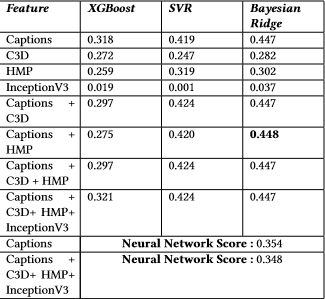

In [4]:
from IPython.display import Image
Image(filename="/content/drive/My Drive/Short_term_score_table.png",width="500",height="300")

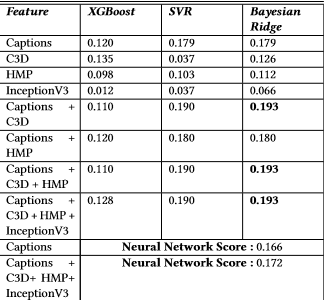

In [5]:
Image(filename="/content/drive/My Drive/Long_term_score_table.png",width="500",height="300")

##**6.Predicting Test Results:**

####**6.1 Importing test Ground-truth CSV file and Test Captions**

In [0]:
#importing test Dataset
csv_path ='/content/drive/My Drive/CA684_Assignment/Test-set/Ground-truth_test/ground_truth_template.csv'
test_dataset = pd.read_csv(csv_path)

In [0]:
#Need to Predict the Short-term memorability and Long-Term memorability score for these videos
test_dataset.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


###Loading Test Captions

In [0]:
# Extract the captions of test dataset
cap_path = '/content/drive/My Drive/CA684_Assignment/Test-set/Captions_test/test-set-1_video-captions.txt'
test_cap = read_caps(cap_path)

In [0]:
#printing the dimensions of test-set dataset and features
print(f'Test-Dataset : {test_dataset.shape}')
print(f'Test-Captions: {test_cap.shape}')

Test-Dataset : (2000, 5)
Test-Captions: (2000, 2)


###**6.2 Extracting Features(Captions,C3D,HMP and InceptionV3) for Test Dataset**

In [0]:
#Extracting Captions Features for Test Dataset
testset_captions = Processing_captions(test_cap)

In [0]:
#Captions of (2000) Videos in Test Dataset
testset_captions.shape

(2000, 3112)

###Captions features of dev-set of Full 6000 files

In [0]:
#Captions of (6000) Videos in Dev Dataset
captions_bag.shape

(6000, 3112)

###C3D features extraction of test dataset

In [0]:
#Extracting C3D features of Test Dataset
test_c3dPath = '/content/drive/My Drive/CA684_Assignment/Test-set/C3D_test/'
test_c3dfeatures = load_c3d(test_cap,test_c3dPath)

In [0]:
#Saving the C3D Test Features 
np.save('/content/drive/My Drive/Features/test_c3dfeatures.npy',test_c3dfeatures)

In [0]:
#To resuse the saved test C3D Features
test_c3dfeatures = np.load('/content/drive/My Drive/Features/test_c3dfeatures.npy')

In [0]:
test_c3dfeatures.shape

(2000, 101)

###HMP features extraction of test dataset

In [0]:
#load HMP features
hmp_path = '/content/drive/My Drive/CA684_Assignment/Test-set/HMP_test/'
test_hmp_features = load_hmp(test_cap,hmp_path)

In [0]:
np.save('/content/drive/My Drive/Features/test_hmp_features.npy',test_hmp_features)

In [0]:
test_hmp_features = np.load('/content/drive/My Drive/Features/test_hmp_features.npy')

###InceptionV3 features extraction of test dataset

In [0]:
#Extract Inception Features for Test Dataset
test_inceptionv3 = pd.DataFrame(columns = ['video', 'arrayInfo'])

#dir_hmp = './dev-set/HMP'
dir_inceptionv3 = '/content/drive/My Drive/CA684_Assignment/Test-set/Inception_test/'

for filename in os.listdir(dir_inceptionv3):
    if filename.endswith(".txt"):
        path = os.path.join(dir_inceptionv3, filename)
        array = read_inception(path)
        if "-56" in filename:
          filename.replace('-56','')
          fileName= filename.replace(".txt",".webm")
          test_inceptionv3 = test_inceptionv3.append({'video': fileName, 'arrayInfo': array}, ignore_index=True)
    else:
        break

In [0]:
count=0
for item in test_inceptionv3['video']:
  test_inceptionv3['video'][count]=item.replace('-56.webm','').replace('video','')
  count = count + 1

In [0]:
test_inceptionv3["video"] = test_inceptionv3["video"].astype(str).astype(int)

In [0]:
#merging inceptionv3 fetures with captions
test_inception = pd.merge(test_inceptionv3, test_dataset,on='video',how='inner')
test_inception.columns
test_inception.head()

,video,arrayInfo,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,9587,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,33,NaN,10
1,9590,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,33,NaN,14
2,9591,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,33,NaN,14
3,9588,"[2.138953e-24, 1.507278e-27, 1.134265e-33, 9.2...",NaN,30,NaN,10
4,9589,"[1.154495e-21, 3.462045e-24, 1.091448e-24, 3.8...",NaN,36,NaN,15


In [0]:
test_inception_features = np.empty((0, 6075))
test_inception_features

for line in test_inception['arrayInfo']:
    #result = do_stuff(line)
    #print(len(line))
    test_inception_features = np.append(test_inception_features, np.array([line]), axis = 0)

In [0]:
test_inception_features

array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 4.718367e-25, 1.557708e-35, ..., 0.000000e+00,
        0.000000e+00, 4.112348e-37],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [0]:
np.save('/content/drive/My Drive/Features/test_inception_features.npy',test_inception_features)

In [0]:
test_inception_features = np.load('/content/drive/My Drive/Features/test_inception_features.npy')

###Combination of Captions,C3D,HMP and InceptionV3 features for Test Dataset

In [0]:
#Combinig Captions,C3D,HMP and InceptionV3 test features

#Combining Captions + C3D
test_captions_c3d = (testset_captions.tolist())
counter = 0
for item in range(2000):
    test_captions_c3d[counter] = np.append(test_captions_c3d[counter],test_c3dfeatures[counter],axis=0)
    counter = counter+1

#Combining Captions + C3D + HMP
test_captions_c3d_hmp = test_captions_c3d
counter = 0
for item in range(2000):
    test_captions_c3d_hmp[counter] = np.append(test_captions_c3d_hmp[counter],test_hmp_features[counter],axis=0)
    counter = counter+1
    
#Combining Captions + C3D + HMP + InceptionV3
test_captions_c3d_hmp_inc = test_captions_c3d_hmp
counter = 0
for item in range(2000):
    test_captions_c3d_hmp_inc[counter] = np.append(test_captions_c3d_hmp_inc[counter],test_inception_features[counter],axis=0)
    counter = counter+1

###**6.3 Predicting the Scores and Exporting the Results**

In [0]:
#Applying Bayesian Regressor on Captions and C3D features which had performed well for Dev set(Short-term score:,Long-term score:)
short_test_pred = BR_Regressor(captions_c3d_hmp_inc,y_short,test_captions_c3d_hmp_inc)
long_test_pred = BR_Regressor(captions_c3d_hmp_inc,y_long,test_captions_c3d_hmp_inc)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
len(short_test_pred)

2000

In [0]:
print(short_test_pred)

[0.85970024 0.8830405  0.84080566 ... 0.88965916 0.81365762 0.89450166]


In [0]:
len(long_test_pred)

2000

In [0]:
print(long_test_pred)

[0.78249669 0.770627   0.78401347 ... 0.79321462 0.75544648 0.79580831]


In [0]:
test_dataset['short-term_memorability'] = short_test_pred
test_dataset['long-term_memorability'] = long_test_pred

In [0]:
test_dataset

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,0.859700,33,0.782497,12
1,7495,0.883040,34,0.770627,10
2,7496,0.840806,32,0.784013,13
3,7497,0.890643,33,0.785353,10
4,7498,0.855606,33,0.774210,10
...,...,...,...,...,...
1995,10004,0.878908,34,0.757811,17
1996,10005,0.874964,34,0.778882,9
1997,10006,0.889659,34,0.793215,12
1998,10007,0.813658,34,0.755446,12


In [0]:
test_dataset.to_csv("/content/drive/My Drive/Features/Results_Final.csv",index=False)

###Done